### Coronaviruses (CoV) are a large family of viruses that cause illness ranging from the common cold to more severe diseases such as Middle East Respiratory Syndrome (MERS-CoV) and Severe Acute Respiratory Syndrome (SARS-CoV). A novel coronavirus (nCoV) is a new strain that has not been previously identified in humans.  
#### Coronaviruses are zoonotic, meaning they are transmitted between animals and people.  Detailed investigations found that SARS-CoV was transmitted from civet cats to humans and MERS-CoV from dromedary camels to humans. Several known coronaviruses are circulating in animals that have not yet infected human.

With the news coming in that the World Health Organization has declared the novel coronavirus outbreak a public health emergency, it has increased the general fear among the public. A lot of countires have heightened their measures to fight with this virus with the condition in China still senitive..More than 20 countries and territories outside of mainland China have confirmed cases of the virus -- spanning Asia, Europe, North America and the Middle East -- as India, Italy and the Philippines reported their first cases on Thursday.

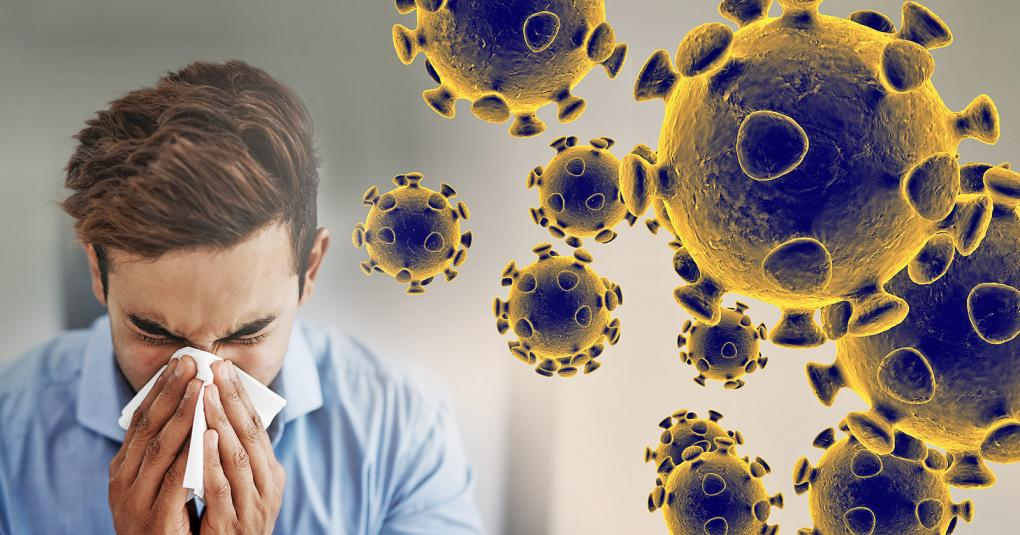

https://www.fda.gov/emergency-preparedness-and-response/mcm-issues/novel-coronavirus-covid-19

### In this notebook I have tried to jot down the basic analysis of Coronavirus learning from various source, Thanks for visiting this notebook. 
#### Your valuable feedback will be appreciated.

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import glob
import os
import random

# visualization
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import folium
import plotly as py
import plotly.express as px
import plotly.graph_objs as go

import datetime

# Import DataSet

In [ ]:

#NCOV_data = pd.read_csv(r"C:\Code\Novel Coronavirus\novel-corona-virus-2019-dataset/NCOV_data.csv")
#covid_19_data = pd.read_csv(r"C:\Code\Novel Coronavirus\novel-corona-virus-2019-dataset/covid_19_data.csv",parse_dates= True, index_col= 'Sno')
#time_series_covid_19_confirmed = pd.read_csv(r"C:\Code\Novel Coronavirus\novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv")
#time_series_covid_19_deaths = pd.read_csv(r"C:\Code\Novel Coronavirus\novel-corona-virus-2019-dataset/time_series_covid_19_deaths.csv")
#time_series_covid_19_recovered = pd.read_csv(r"C:\Code\Novel Coronavirus\novel-corona-virus-2019-dataset/time_series_covid_19_recovered.csv")
#cn_geo_data = (r"C:\Code\Novel Coronavirus\novel-corona-virus-2019-dataset/china.json")
#world_coordinates = pd.read_csv(r"C:\Code\Novel Coronavirus\novel-corona-virus-2019-dataset/world_coordinates.csv", index_col= 'Country')



In [ ]:
NCOV_data = pd.read_csv('../input/corona/NCOV_data.csv')
time_series_covid_19_confirmed = pd.read_csv('../input/corona/time_series_covid_19_confirmed.csv')
time_series_covid_19_deaths = pd.read_csv('../input/corona/time_series_covid_19_deaths.csv')
time_series_covid_19_recovered = pd.read_csv('../input/corona/time_series_covid_19_recovered.csv')
world_coordinates = pd.read_csv('../input/corona/world_coordinates.csv')


## <a id='basic'>1. Basic Exploration</a>

In [ ]:
NCOV_data.head()

In [ ]:
NCOV_data.tail()

In [ ]:
NCOV_data.info()

In [ ]:
NCOV_data.shape

In [ ]:
NCOV_data.isnull().sum()

In [ ]:
NCOV_data.describe()

Top Country Affected in this scenario

In [ ]:
# Countries affected

countries = NCOV_data['Country'].unique().tolist()
print(countries)

print("\nTotal countries affected by virus: ",len(countries))

In [ ]:
#Combining China and Mainland China cases as they are provided separately

NCOV_data['Country'].replace({'Mainland China':'China'},inplace=True)
countries = NCOV_data['Country'].unique().tolist()
print(countries)
print("\nTotal countries affected by virus: ",len(countries))


## <a id='basic'>Let's Fix the datetime</a>

In [ ]:
# Convert Last Update column to datetime64 format

from datetime import date

NCOV_data['Date'] = NCOV_data['Date'].apply(pd.to_datetime)
#NCOV_data.drop(['Sno'],axis=1,inplace=True)

#Set Date column as the index column.
#data.set_index('Last Update', inplace=True)
#NCOV_data.head()


d = NCOV_data['Date'][-1:].astype('str')
year = int(d.values[0].split('-')[0])
month = int(d.values[0].split('-')[1])
day = int(d.values[0].split('-')[2].split()[0])


data_latest = NCOV_data[NCOV_data['Date'] > pd.Timestamp(date(year,month,day))]
data_latest.head()


# <a id='basic'>EDA</a>

In [ ]:
NCOV_data.groupby('Date').sum()['Confirmed'].plot()
plt.grid()

In [ ]:
NCOV_data.groupby('Date').sum()['Deaths'].plot()
plt.grid()

In [ ]:
country_count = NCOV_data['Country'].value_counts().reset_index()
country_count = country_count.rename(columns={"index": "Country", "Country": "Count"})
country_count.head()

In [ ]:
country_count = pd.DataFrame(NCOV_data.groupby('Country')['Confirmed'].max()).reset_index()
country_count.head()

In [ ]:
country_count_wo_mc=country_count[country_count.Country != 'Mainland China']
country_count_wo_mc.head()

In [ ]:
plt.figure(figsize=(20,20))
fig = go.Figure(data = [go.Pie(labels = country_count_wo_mc.Country,values = country_count_wo_mc.Confirmed)])
fig.update_layout(title="Country-wise distribution except Mainland China")
fig.show()

In [ ]:
state_count = pd.DataFrame(NCOV_data[NCOV_data['Country']=='Mainland China'].groupby('Province/State').max()['Confirmed']).reset_index()
fig = go.Figure(data = [go.Pie(labels = state_count['Province/State'],values = state_count.Confirmed)])
fig.update_layout(title="State-wise distribution of Mainland China")
fig.show()


# <a id='basic'>Growth trend of Corona virus in each Country individually</a>

In [ ]:

growth_country = pd.pivot_table(NCOV_data[NCOV_data.Country!='Mainland China'], values='Confirmed', columns='Country', index='Date')
growth_country.plot(figsize=(18,12))

In [ ]:
# Creating a dataframe with total no of confirmed cases for every country
Number_of_countries = len(data_latest['Country'].value_counts())


cases = pd.DataFrame(data_latest.groupby('Country')['Confirmed'].sum())
cases['Country'] = cases.index
cases.index=np.arange(1,Number_of_countries+1)

global_cases = cases[['Country','Confirmed']]


global_cases

In [ ]:
# Importing the world_coordinates dataset


# Merging the coordinates dataframe with original dataframe
world_data = pd.merge(world_coordinates,global_cases,on='Country')
world_data.head()


# <a id='basic'>Lets visualize where the desease spread geographically</a>

In [ ]:
# create map and display it
world_map = folium.Map(location=[10, -20], zoom_start=2.3,tiles='Stamen Toner')

for lat, lon, value, name in zip(world_data['latitude'], world_data['longitude'], world_data['Confirmed'], world_data['Country']):
    folium.CircleMarker([lat, lon],
                        radius=10,
                        popup = ('<strong>Country</strong>: ' + str(name).capitalize() + '<br>'
                                '<strong>Confirmed Cases</strong>: ' + str(value) + '<br>'),
                        color='red',
                        
                        fill_color='red',
                        fill_opacity=0.7 ).add_to(world_map)
world_map

# <a id='basic'>Checking the data set what we have been imported earlier </a>

In [ ]:
time_series_covid_19_confirmed.head()

In [ ]:
time_series_covid_19_deaths.head()

In [ ]:
time_series_covid_19_recovered.head()

In [ ]:
df= pd.read_csv('../input/corona/covid_19_data.csv', parse_dates= True, index_col= 'SNo')

In [ ]:
#df= pd.read_csv(r'C:\Code\Novel Coronavirus\novel-corona-virus-2019-dataset\covid_19_data.csv', parse_dates= True, index_col= 'SNo')
df['ObservationDate']= pd.to_datetime(df['ObservationDate']).dt.date
df['Last Update']= pd.to_datetime(df['Last Update']).dt.date
#df.set_index('ObservationDate', inplace= True)
df.head(5)

In [ ]:
df.shape

In [ ]:
df.isnull().sum()

In [ ]:
df.describe()

In [ ]:
df1= df.rename(columns={'Country/Region':'Country'})

In [ ]:
df1.info()

In [ ]:
df1.head()

In [ ]:
df1['Country'].replace({'Mainland China': 'China'}, inplace= True)
recent_cp_df= df1.groupby(['Country', 'Province/State']).last()
recent_cp_df

In [ ]:
recent_cp_df_c= recent_cp_df.groupby('Country').agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum'})
recent_cp_df_c['Recovery Rate']= recent_cp_df_c['Recovered']/recent_cp_df_c['Confirmed']
recent_cp_df_c['Mortality Rate']= recent_cp_df_c['Deaths']/recent_cp_df_c['Confirmed']
recent_c_df=  df1

for i in recent_cp_df_c.index:
    recent_c_df= recent_c_df[(recent_c_df['Country']!=i)]
    
recent_c_df= recent_c_df.groupby(['Country']).last()
recent_c_df.drop(['Province/State', 'Last Update'], axis= 1, inplace= True)
recent_c_df['Recovery Rate']= recent_c_df['Recovered']/recent_c_df['Confirmed']
recent_c_df['Mortality Rate']= recent_c_df['Deaths']/recent_c_df['Confirmed']

recent_df= pd.concat([recent_cp_df_c, recent_c_df], axis= 0)
recent_df

In [ ]:
# We notice NA values for Brazil, Ivory Coast & Mexico. We can drop them since they have no confirmed cases.
#Confirmed vs Deaths vs Recovered for all countries except China
for i in ['Brazil', 'Ivory Coast', 'Mexico']:
    df= df1[(df1['Country']!=i)]

recent_df_nc= recent_df.drop(['China']).sort_values(['Confirmed'], ascending= False)
recent_df_nc

In [ ]:
f, ax = plt.subplots(figsize=(20, 10))
sns.barplot(x= recent_df_nc["Confirmed"], y= recent_df_nc.index, label="Confirmed", color="blue")
sns.barplot(x= recent_df_nc["Recovered"], y= recent_df_nc.index, label="Recovered", color="green")
sns.barplot(x= recent_df_nc["Deaths"], y= recent_df_nc.index, label="Deaths", color="red")
sns.despine(left= True)
ax.legend(ncol=5, loc="lower right")
ax.set(ylabel="Countries", xlabel="Values")

In [ ]:
print('Globally, these are the total numbers reported yet: ')
recent_df.agg({'Confirmed': 'sum', 'Deaths': 'sum', 'Recovered': 'sum', 'Recovery Rate': 'mean', 'Mortality Rate': 'mean'}).to_frame()

In [ ]:
recent_df.sort_values(['Confirmed'], ascending= False)

In [ ]:
recent_df.sort_values(['Mortality Rate'], ascending= False)

In [ ]:
recent_df.sort_values(['Recovery Rate'], ascending= True)

In [ ]:
world_coordinates.head()

In [ ]:
recent_df.head()

In [ ]:
world_coordinates.info()

In [ ]:
recent_df.columns

In [ ]:
recent_df.info()

In [ ]:
#recent_df= recent_df.join(world_coordinates, how= 'inner')
recent_df.drop(['Brazil', 'Mexico'], inplace= True)
recent_df

In [ ]:
c = random.choices(list(mcolors.CSS4_COLORS.values()),k = len(countries))
plt.figure(figsize=(20,20))
plt.pie(recent_c_df['Confirmed'], colors=c)
plt.legend(countries, loc='best')
plt.show()

In [ ]:
world_map = folium.Map(location=[35.861660, 80.195397], zoom_start= 3, tiles='Stamen Toner')
outbreaks = folium.map.FeatureGroup()

for lt, ln, nm, cnfrm, rec, mor in zip(recent_df['latitude'], recent_df['longitude'], recent_df.index, recent_df['Confirmed'], recent_df['Recovery Rate'], recent_df['Mortality Rate']):
    ss= '<b>Country: </b>' + nm + '<br><b>#Confirmed: </b>' + str(int(cnfrm)) + '<br><b>Recovery rate: </b>' + str(round(rec, 2)) + '<br><b>Mortality rate: </b>' + str(round(mor, 2))
    folium.Marker([lt, ln], popup= ss).add_to(world_map) 
    folium.CircleMarker([lt, ln], radius= 0.05*int(cnfrm), color= 'red').add_to(world_map) 
    
world_map

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
                x=NCOV_data["Country"],
                y=NCOV_data["Confirmed"],
                marker_color='darkorange',
                marker_line_color='rgb(8,48,107)',
                marker_line_width=2, 
                opacity=0.7))

fig.update_layout(
    title_text='Confirmed Cases on Provinces of China (Till February 17, 2020)',
    height=700, width=800, xaxis_title='Province/State', yaxis_title='Confirmed')

fig.show()

In [ ]:
fig = go.Figure()

fig.add_trace(go.Bar(
                x=NCOV_data["Province/State"],
                y=NCOV_data["Recovered"],
                marker_color='mediumturquoise',
                name="Recovered"))

fig.add_trace(go.Bar(
                x=NCOV_data["Province/State"],
                y=NCOV_data["Deaths"],
                marker_color='red',
                name="Deaths"))

fig.update_traces(marker_line_color='rgb(8,48,107)',
                  marker_line_width=2, opacity=0.7)

fig.update_layout(
    title_text='Death/Recovered Rate in the Other China Provinces Except Wuhan',
    height=600, width=800, xaxis_title='Province/State')

fig.show()

In [ ]:

time_series_covid_19_confirmed = np.sum(time_series_covid_19_confirmed.iloc[:,4:time_series_covid_19_confirmed.shape[1]])
time_series_covid_19_recovered = np.sum(time_series_covid_19_recovered.iloc[:,4:time_series_covid_19_recovered.shape[1]])
time_series_covid_19_deaths = np.sum(time_series_covid_19_deaths.iloc[:,4:time_series_covid_19_deaths.shape[1]])

global_mortality = time_series_covid_19_deaths/(time_series_covid_19_confirmed+time_series_covid_19_recovered+time_series_covid_19_deaths)*100

# defyning plotsize
plt.figure(figsize=(20,10))

# creating a lineplot for each case variable(suspected, recovered and death)
plt.plot(global_mortality
        , color = 'red'
        , label = 'Mortality Rate'
        , marker = 'o')

# defyning titles, labels and ticks parameters
plt.title('Global Mortality Rate Over the Time',size=30)
plt.ylabel('Rate',size=20)
plt.xlabel('Updates',size=20)
plt.xticks(rotation=45,size=15)
plt.yticks(size=15)

# defyning legend parameters
plt.legend(loc = "upper right"
           , frameon = True
           , fontsize = 15
           , ncol = 1
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1);


In [ ]:
confirmed = time_series_covid_19_confirmed 
confirmed.head()

In [ ]:
# taking cases numbers
Hubei = china_cases[china_cases.index=="Hubei"]
Hubei = Hubei.iloc[0]

# difyning plot size
plt.figure(figsize=(15,15))

# here i use .value_counts() to count the frequency that each category occurs of dataset
Hubei.plot(kind='pie'
           , colors=['#4b8bbe','lime','red']
           , autopct='%1.1f%%' # adding percentagens
           , shadow=True
           , startangle=140)

# defyning titles and legend parameters
plt.title('Hubei Cases Distribution',size=30)
plt.legend(loc = "upper right"
           , frameon = True
           , fontsize = 15
           , ncol = 2 
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1);